In [1]:
# importing module
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from myutils import *
from SLBQP import SLBQP
from datastorer import DataStorer
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
params = {
    'figure.figsize': (20, 10),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

In [2]:
df_gold = pd.read_csv('GOLDSTEIN_WHOLE_ML_DATASET.csv')
df_ros = pd.read_csv('ROSEN_WHOLE_ML_DATASET.csv')

In [3]:
f_star = df_gold['val'].to_numpy()[-1]

In [4]:
fi = df_gold['val'].copy()
fi = fi - f_star
fii = fi.copy()
# delete first element from fi and last from fii
fi.drop(index=0, inplace=True)
fii.drop(index=(len(fii)-1), inplace=True)

In [5]:
fi = fi.to_numpy()
fii = fii.to_numpy()

In [6]:
convergence_gold = fi #/ fii

In [7]:
print(len(convergence_gold))

5366


(-1.0, 30.0)

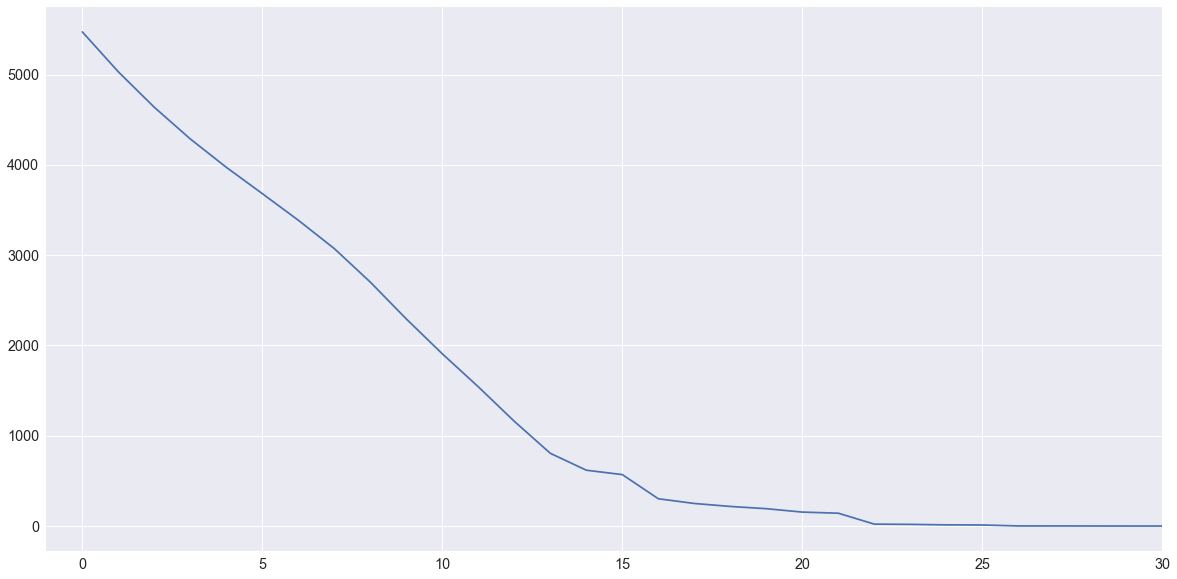

In [8]:
plt.plot([*range(len(convergence_gold))], convergence_gold)
#plt.ylim(-1, 10)
plt.xlim(-1, 30)

True


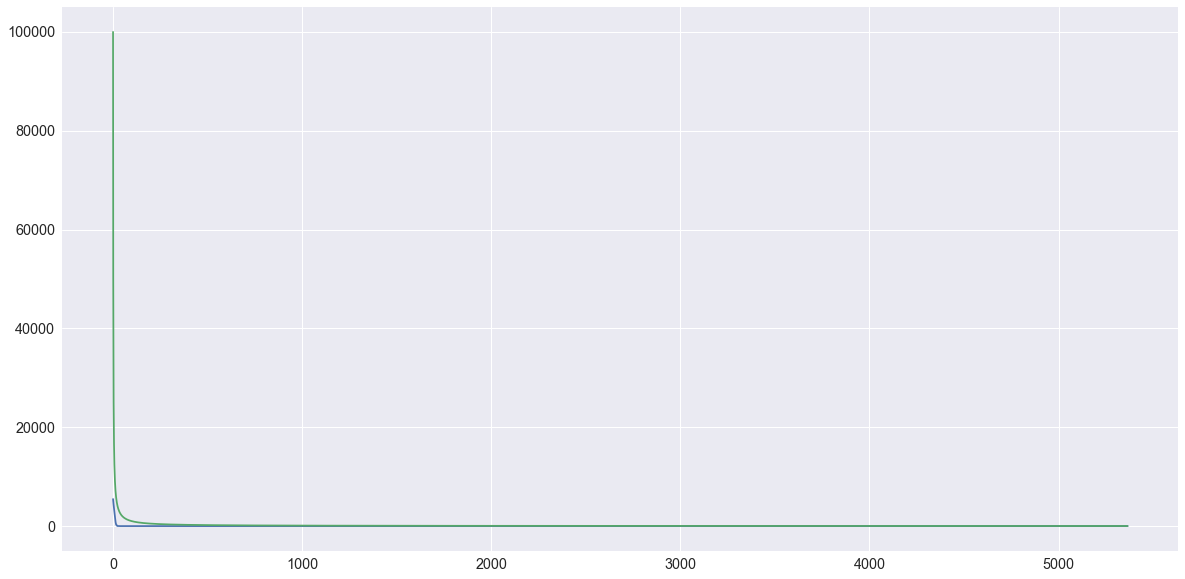

In [9]:
plt.plot([*range(len(convergence_gold))], convergence_gold)

hyp = [1e5*(1/(1+n)) for n in range(len(convergence_gold))]
print(all(convergence_gold < hyp))
plt.plot([*range(len(convergence_gold))], hyp)

In [10]:
xnorm = df_gold['xnorm'].to_numpy()

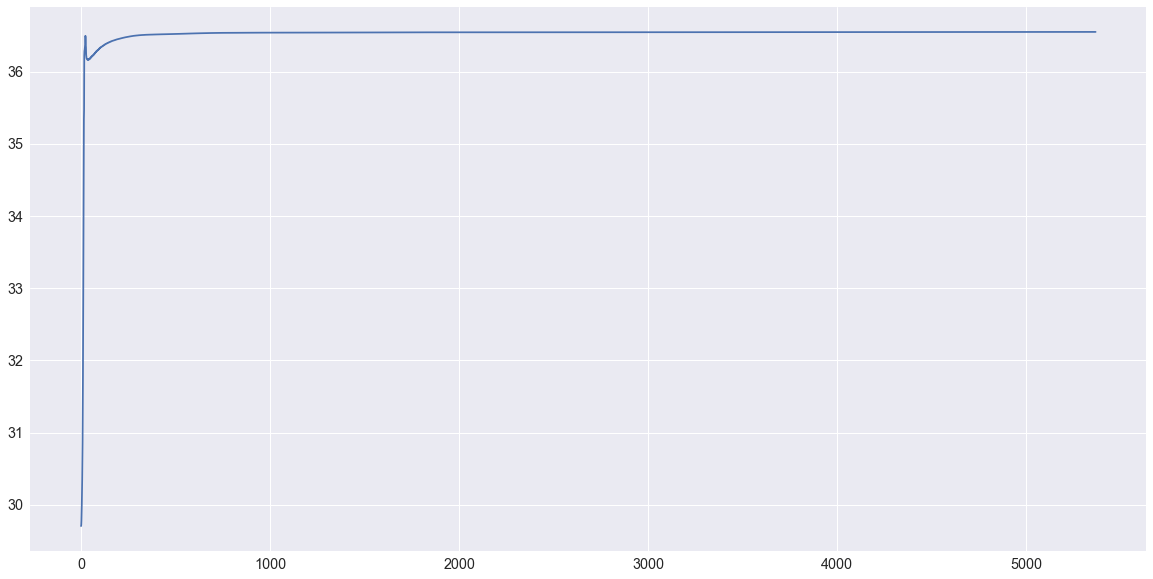

In [11]:
plt.plot([*range(len(xnorm))], xnorm)

# ROSEN

In [12]:
#f_star = df_ros['val'].to_numpy()[-1]

In [13]:
fi = df_ros['val'].copy()
fi = fi - f_star
fii = fi.copy()
# delete first element from fi and last from fii
fi.drop(index=0, inplace=True)
fii.drop(index=(len(fii)-1), inplace=True)

In [14]:
fi = fi.to_numpy()
fii = fii.to_numpy()

In [15]:
convergence_ros = fi #/ fii

In [16]:
print(len(convergence_ros))

9105


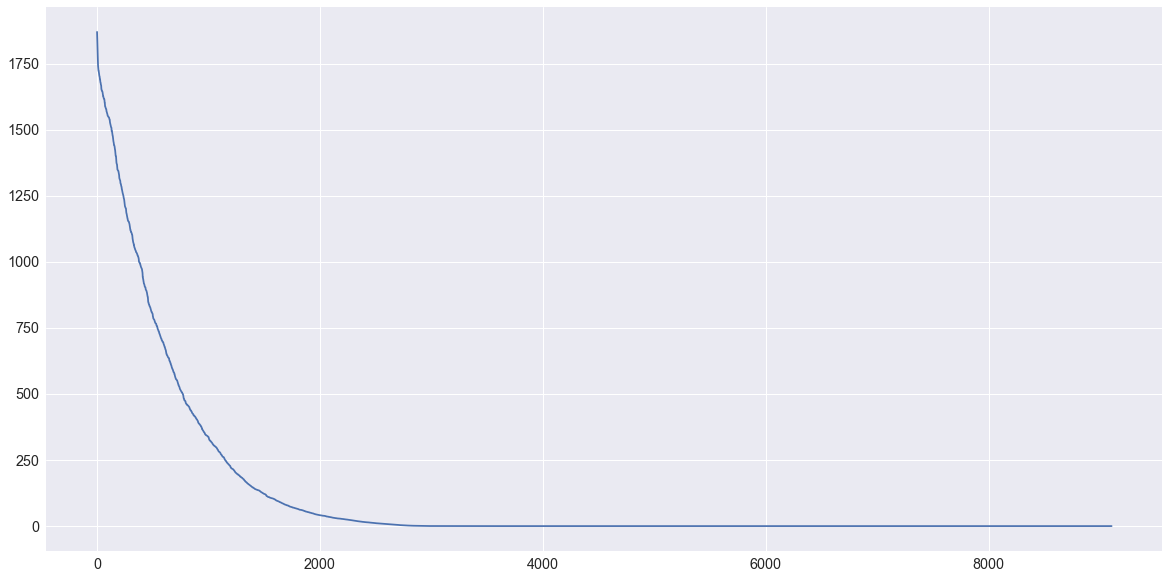

In [17]:
plt.plot([*range(len(convergence_ros))], convergence_ros)

In [18]:
xnorm = df_ros['xnorm'].to_numpy()

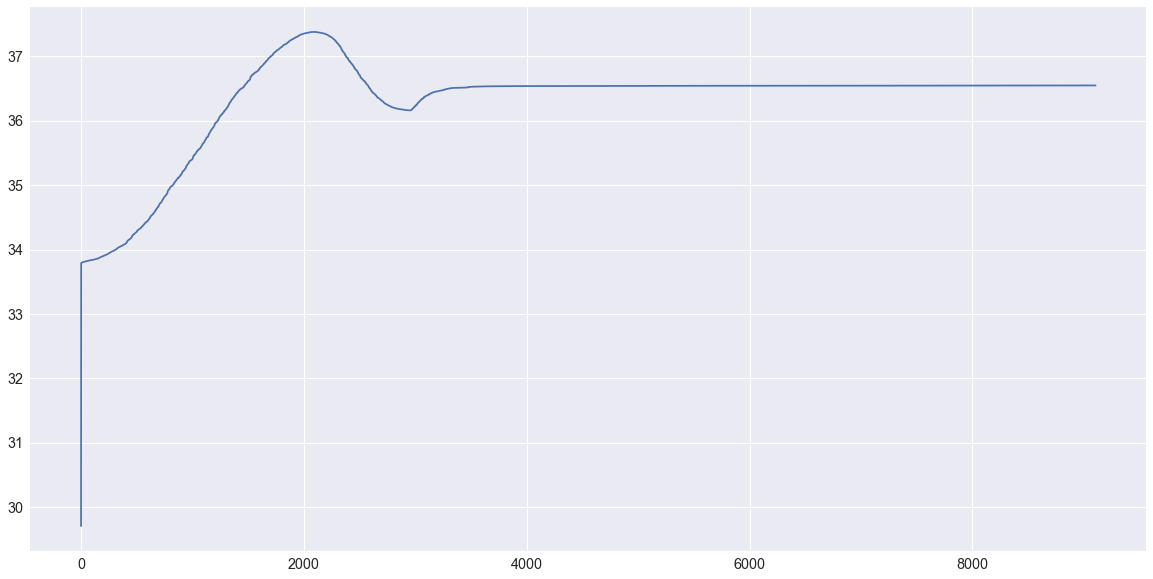

In [19]:
plt.plot([*range(len(xnorm))], xnorm)


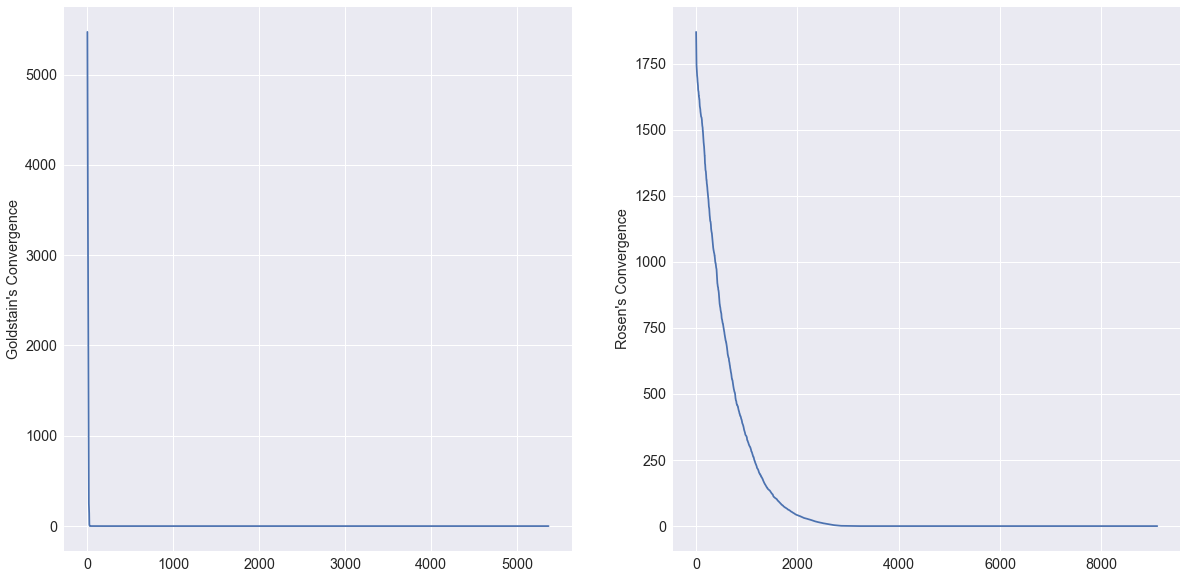

In [20]:
fig, (ax0, ax1) = plt.subplots(ncols=2)
ax0.set_ylabel("Goldstain's Convergence")
ax0.plot([*range(len(convergence_gold))], convergence_gold)
ax1.set_ylabel("Rosen's Convergence")
ax1.plot([*range(len(convergence_ros))], convergence_ros)

# Valore che scende

In [21]:
val_gold = df_gold['val']
val_ros = df_ros['val']

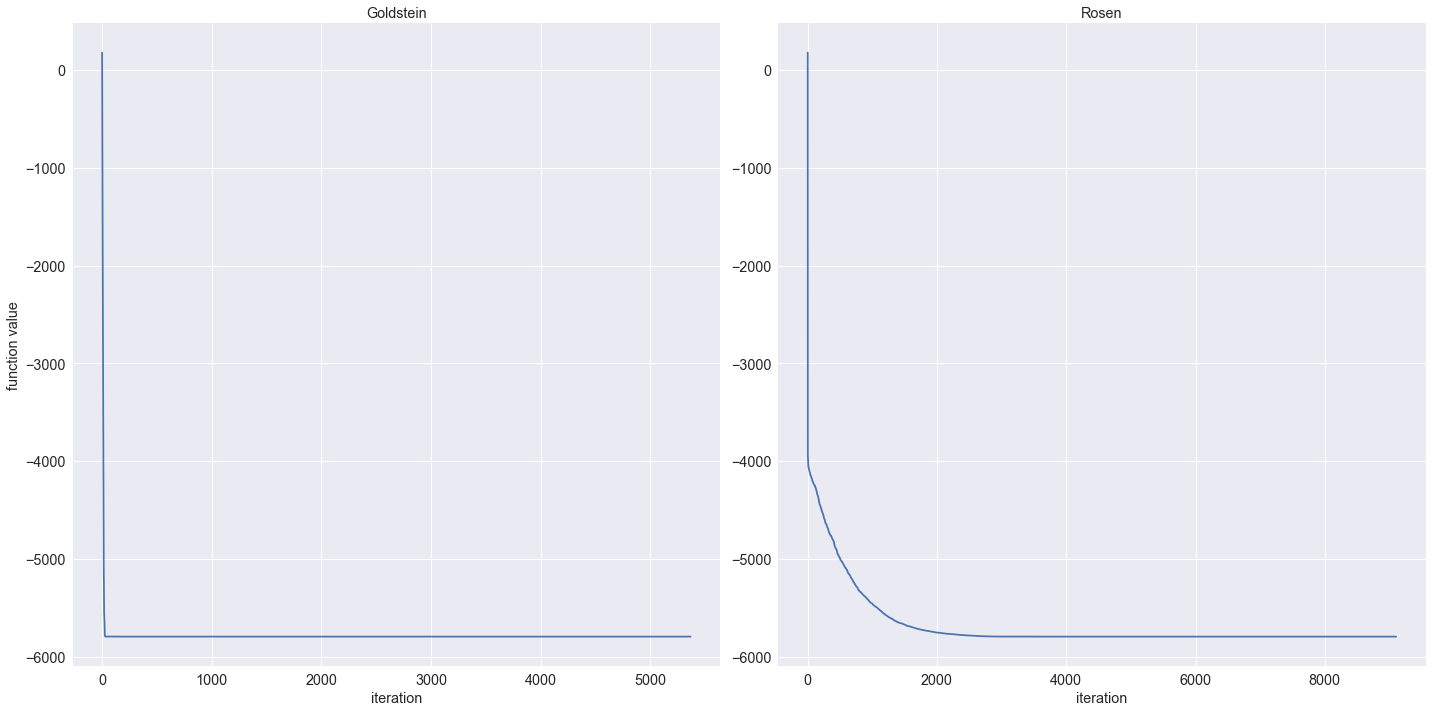

In [39]:
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=False)
val_gold.plot(ax=ax0)
val_ros.plot(ax=ax1)
ax0.set_ylabel("function value")
ax1.set_xlabel("iteration")
ax0.set_xlabel("iteration")
ax0.set_title("Goldstein")
ax1.set_title("Rosen")
plt.tight_layout()

# Multiple plots

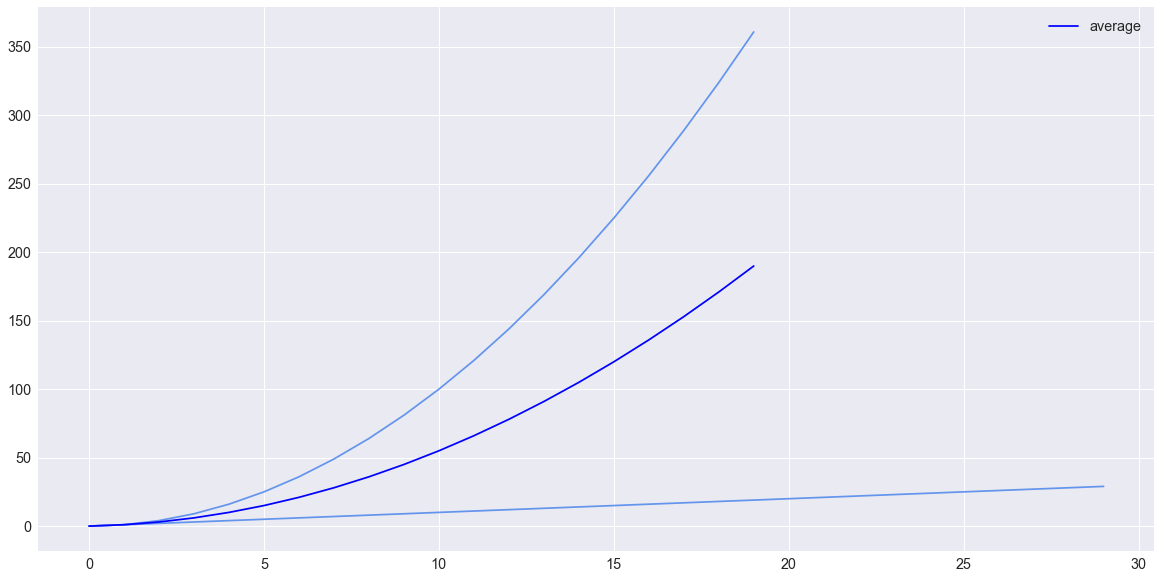

In [23]:
x = [i for i in range(30)]
z = [i**2 for i in range(20)]
plot_multiple_functions([x, z], plot_avg=True)

# Inizio esperimenti seri

In [24]:
def extract_optimal_values(size):
    """reads the file containing the optimal values and returns an array with the values"""
    assert(size in [i*1e2 for i in range(1,11)])
    lines = None
    path = f"CSV/{size}/optimal_values.txt"
    with open(path, "r") as f:
        lines = f.readlines()
        lines = [np.float(i.strip()) for i in lines]
    return np.array(lines)

def load_problems_measure(size, measure='val', alg='goldstein'):
    """extract one column from all the csv of that size and algorithm"""
    prob = "GOLD" if (alg.lower().startswith('g')) or (type(alg) is int and alg == 1) else "ROS"
    path = f"CSV/{size}/{prob}/" + "{}.csv"
    problem_values = []
    for i in range(10):
        filepath = path.format(str(i))
        problem_values.append(pd.read_csv(filepath, usecols=[measure]).to_numpy())
    return problem_values


In [25]:
optimal_values = {} # dictionary indexed by problem size
for size in [int(i*1e2) for i in range(1,11)]:
    optimal_values[str(size)] = extract_optimal_values(size)

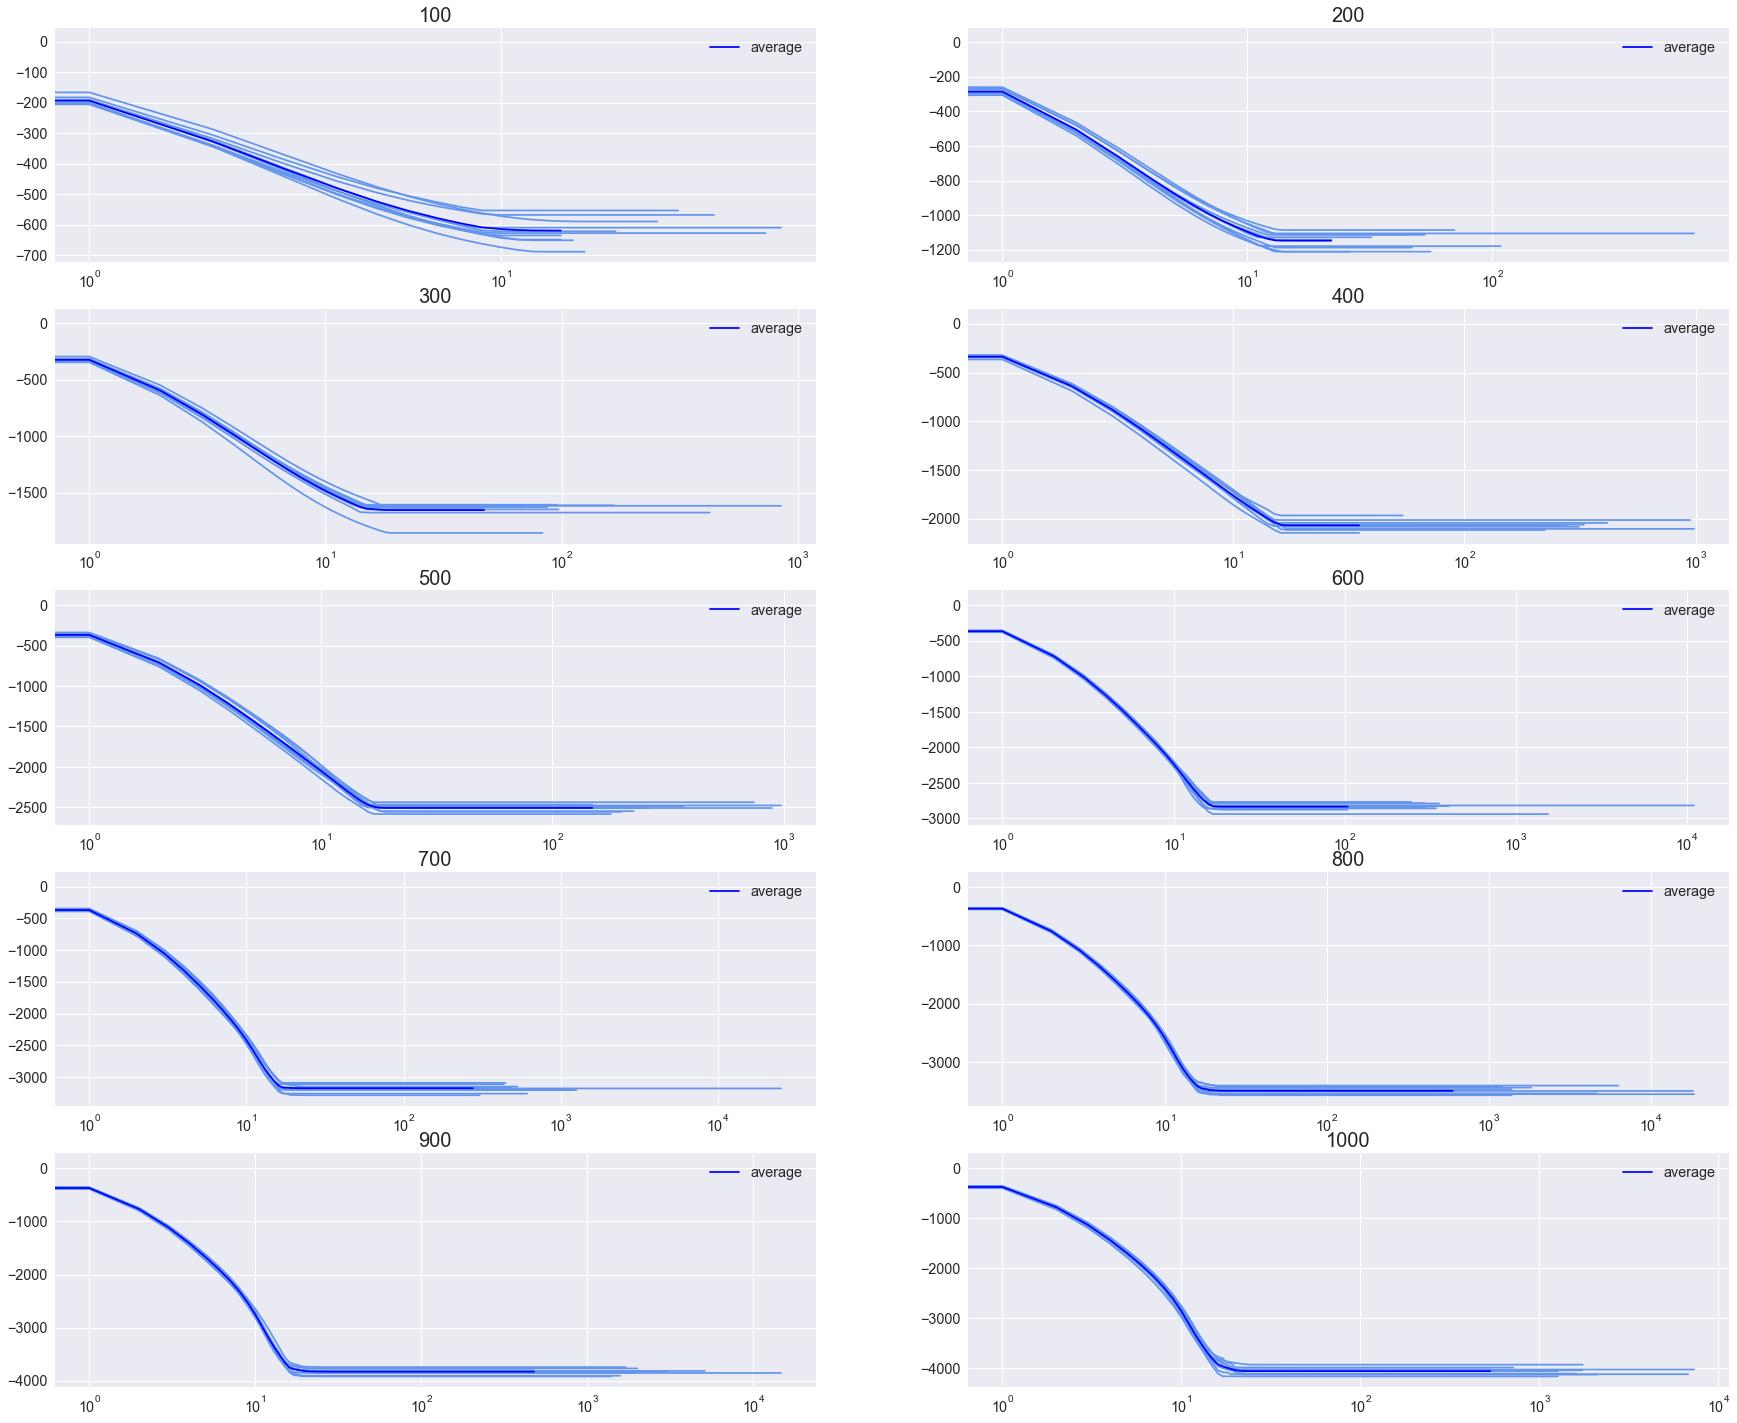

In [40]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30,25))
for (i, ax) in enumerate(fig.axes):
    size = int((i+1)*1e2)
    values = load_problems_measure(str(size))
    plot_multiple_functions(values, plot_avg=True, ax=ax)
    ax.set_title(str(size), fontdict={'fontsize': 20})
    ax.set_xscale("log") # use logaritmic scale for x